In [303]:
import os
import glob
import subprocess
import numpy as np
from numpy import cov
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import optimize
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.timeseries import LombScargle
from astropy.visualization import astropy_mpl_style
from astropy.visualization import simple_norm
from photutils import CircularAperture
from photutils import aperture_photometry
from photutils import CircularAnnulus
import warnings
warnings.filterwarnings('ignore')
import scipy
def test_func(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

# %matplotlib tk

##### Data Credits: Dr Patrick Tisserand

In [271]:
files = glob.glob('data/*.fits')

In [274]:
columns = ['JD(seconds)']
jd = []
jdai = []
for i in range(len(files)):
    jd.append(float(files[i][10:23])*86400)
    jdai.append(float(files[i][10:23]))

df = pd.DataFrame(columns=columns)
df['JD(seconds)'] = jd
df['JD'] = jdai

df

,JD(seconds),JD
0,2.118434e+11,2.451891e+06
1,2.118435e+11,2.451892e+06
2,2.118434e+11,2.451891e+06
3,2.118434e+11,2.451891e+06
4,2.118437e+11,2.451894e+06
...,...,...
63,2.118435e+11,2.451892e+06
64,2.118435e+11,2.451893e+06
65,2.118436e+11,2.451894e+06
66,2.118435e+11,2.451893e+06


## Aperture Photometry

In [275]:
aperture_1 = []
aperture_2 = []
aperture_3 = []


for i in range(len(files)):
    nest_list = []
    hdu = fits.open(files[i])

    w = WCS(hdu[0].header)

#     positions = [(100., 100.),(41,115.5),(150,143)]
#     positions = [(101., 101.),(104,159),(103.5,172.5)]
#     positions = [(101., 101.),(70,99),(103.5,172.5)]

    positions = [(101., 101.),(73.2,118.2),(103,172.5)]    

    aperture = CircularAperture(positions, r=6.)

    image = hdu[0].data

    annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=13)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g' 

    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area

    bkg_sum = bkg_mean * aperture.area
    final_sum = phot_table['aperture_sum_0'] - bkg_sum
    phot_table['residual_aperture_sum'] = final_sum
    phot_table['residual_aperture_sum'].info.format = '%.8g' 

    aperture_1.append(phot_table['residual_aperture_sum'][0])
    aperture_2.append(phot_table['residual_aperture_sum'][1])
    aperture_3.append(phot_table['residual_aperture_sum'][2])

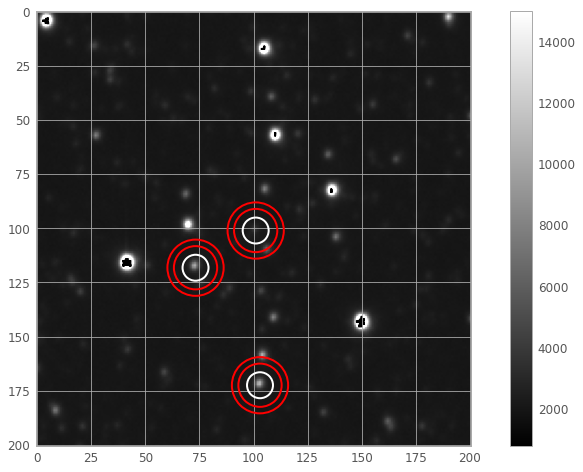

In [318]:
positions = [(101., 101.),(73.2,118.2),(103,172.5)]
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=13)
aperture = CircularAperture(positions, r=6.)

fig, ax = plt.subplots(1,1, figsize=(14,8))

plt.imshow(hdu[0].data,vmin=np.median(image)-1*np.std(image),
               vmax=np.median(image)+10*np.std(image), cmap='gray')
plt.colorbar()

ap_patches = aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
# handles = (ap_patches[0], ann_patches[0])
# plt.legend(facecolor='#458989', labelcolor='white',
#            prop={'weight': 'bold', 'size': 11})

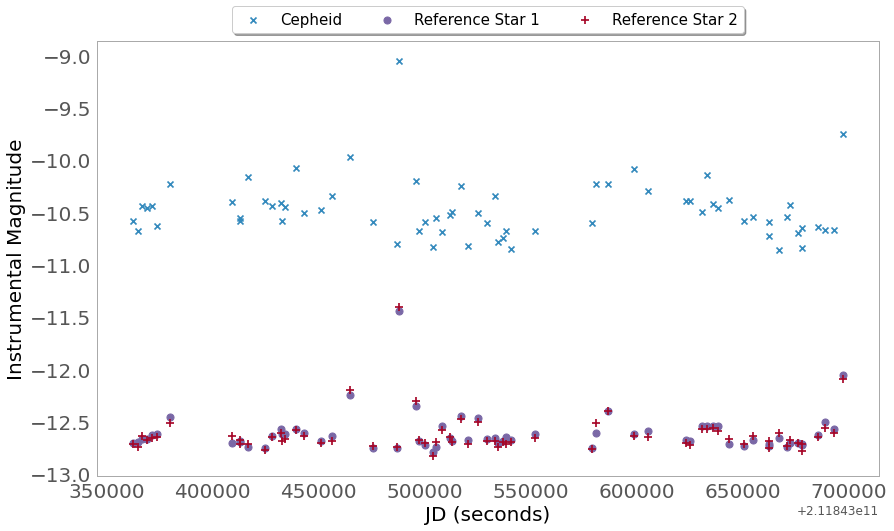

In [278]:
fig, ax = plt.subplots(1,1, figsize=(14,8))

# fig.patch.set_facecolor('lightgrey')
ax.grid(False)

plt.xticks(fontsize= 20) 
plt.yticks(fontsize= 20) 
ax.set_ylabel('Instrumental Magnitude',fontsize=20)
ax.set_xlabel('JD (seconds)', fontsize=20)

ax.scatter(df['JD(seconds)'],df['ins_mag_1'],marker='x', label='Cepheid')
ax.scatter(df['JD(seconds)'],df['ins_mag_2'],s=50,marker='o', label='Reference Star 1')
ax.scatter(df['JD(seconds)'],df['ins_mag_3'],s=50,marker='+', label='Reference Star 2')

ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.),
          fancybox=True, shadow=True, ncol=3, fontsize = 15)

## Differential Photometry

In [276]:
df['residual_aperture_sum_1'] = aperture_1
df['residual_aperture_sum_2'] = aperture_2
df['residual_aperture_sum_3'] = aperture_3

df['ins_mag_1'] = -2.5*np.log10(df['residual_aperture_sum_1'])
df['ins_mag_2'] = -2.5*np.log10(df['residual_aperture_sum_2'])
df['ins_mag_3'] = -2.5*np.log10(df['residual_aperture_sum_3'])

df['diff_mag_1'] = df['ins_mag_1']-df['ins_mag_3']
df['diff_mag_2'] = df['ins_mag_2']-df['ins_mag_3']
df['diff_mag_3'] = df['ins_mag_3']-df['ins_mag_3']

df

,JD(seconds),JD,residual_aperture_sum_1,residual_aperture_sum_2,residual_aperture_sum_3,ins_mag_1,ins_mag_2,ins_mag_3,diff_mag_1,diff_mag_2,diff_mag_3
0,2.118434e+11,2.451891e+06,14430.320889,121142.345510,113838.175256,-10.398190,-12.708240,-12.640720,2.242530,-0.067520,0.0
1,2.118435e+11,2.451892e+06,4162.407179,37613.556798,36421.435689,-9.048361,-11.438361,-11.403393,2.355031,-0.034968,0.0
2,2.118434e+11,2.451891e+06,16654.239669,119936.235002,122230.554717,-10.553812,-12.697376,-12.717949,2.164137,0.020573,0.0
3,2.118434e+11,2.451891e+06,15189.895728,116235.300965,117413.460319,-10.453887,-12.663345,-12.674295,2.220408,0.010950,0.0
4,2.118437e+11,2.451894e+06,17104.785811,124109.375352,121853.757766,-10.582794,-12.734511,-12.714597,2.131803,-0.019914,0.0
...,...,...,...,...,...,...,...,...,...,...,...
63,2.118435e+11,2.451892e+06,9744.843445,79014.607368,75876.753328,-9.971937,-12.244268,-12.200272,2.228335,-0.043997,0.0
64,2.118435e+11,2.451893e+06,15729.997736,118397.049119,119805.729902,-10.491822,-12.683352,-12.696194,2.204372,0.012842,0.0
65,2.118436e+11,2.451894e+06,14192.941138,122433.396516,117018.778501,-10.380181,-12.719750,-12.670639,2.290458,-0.049111,0.0
66,2.118435e+11,2.451893e+06,12576.602360,94936.683607,97906.088030,-10.248908,-12.443585,-12.477024,2.228116,0.033439,0.0


In [277]:
df = df.sort_values(by=['JD(seconds)'])
df = df.reset_index(drop=True)
# df.to_csv('data.csv')
df

,JD(seconds),JD,residual_aperture_sum_1,residual_aperture_sum_2,residual_aperture_sum_3,ins_mag_1,ins_mag_2,ins_mag_3,diff_mag_1,diff_mag_2,diff_mag_3
0,2.118434e+11,2.451891e+06,17045.862694,120860.902408,121980.383524,-10.579047,-12.705715,-12.715725,2.136678,0.010010,0.0
1,2.118434e+11,2.451891e+06,18725.793692,120157.112515,125690.864465,-10.681101,-12.699374,-12.748259,2.067159,0.048886,0.0
2,2.118434e+11,2.451891e+06,14910.494799,116295.951683,113681.191125,-10.433730,-12.663911,-12.639222,2.205491,-0.024690,0.0
3,2.118434e+11,2.451891e+06,15189.895728,116235.300965,117413.460319,-10.453887,-12.663345,-12.674295,2.220408,0.010950,0.0
4,2.118434e+11,2.451891e+06,15029.989218,112994.577985,115575.903251,-10.442397,-12.632644,-12.657168,2.214772,0.024524,0.0
...,...,...,...,...,...,...,...,...,...,...,...
63,2.118437e+11,2.451894e+06,21745.129419,123040.407718,129132.835953,-10.843405,-12.725119,-12.777592,1.934187,0.052472,0.0
64,2.118437e+11,2.451895e+06,17980.222019,112897.929273,114868.431139,-10.636988,-12.631715,-12.650502,2.013514,0.018787,0.0
65,2.118437e+11,2.451895e+06,18515.318741,100608.559082,106154.684557,-10.668828,-12.506587,-12.564848,1.896020,0.058261,0.0
66,2.118437e+11,2.451895e+06,18530.102162,106923.364736,110902.153894,-10.669695,-12.572682,-12.612350,1.942655,0.039668,0.0


[1.18854826e-01 4.00000222e-05 4.91656249e+02 2.17740518e+00]


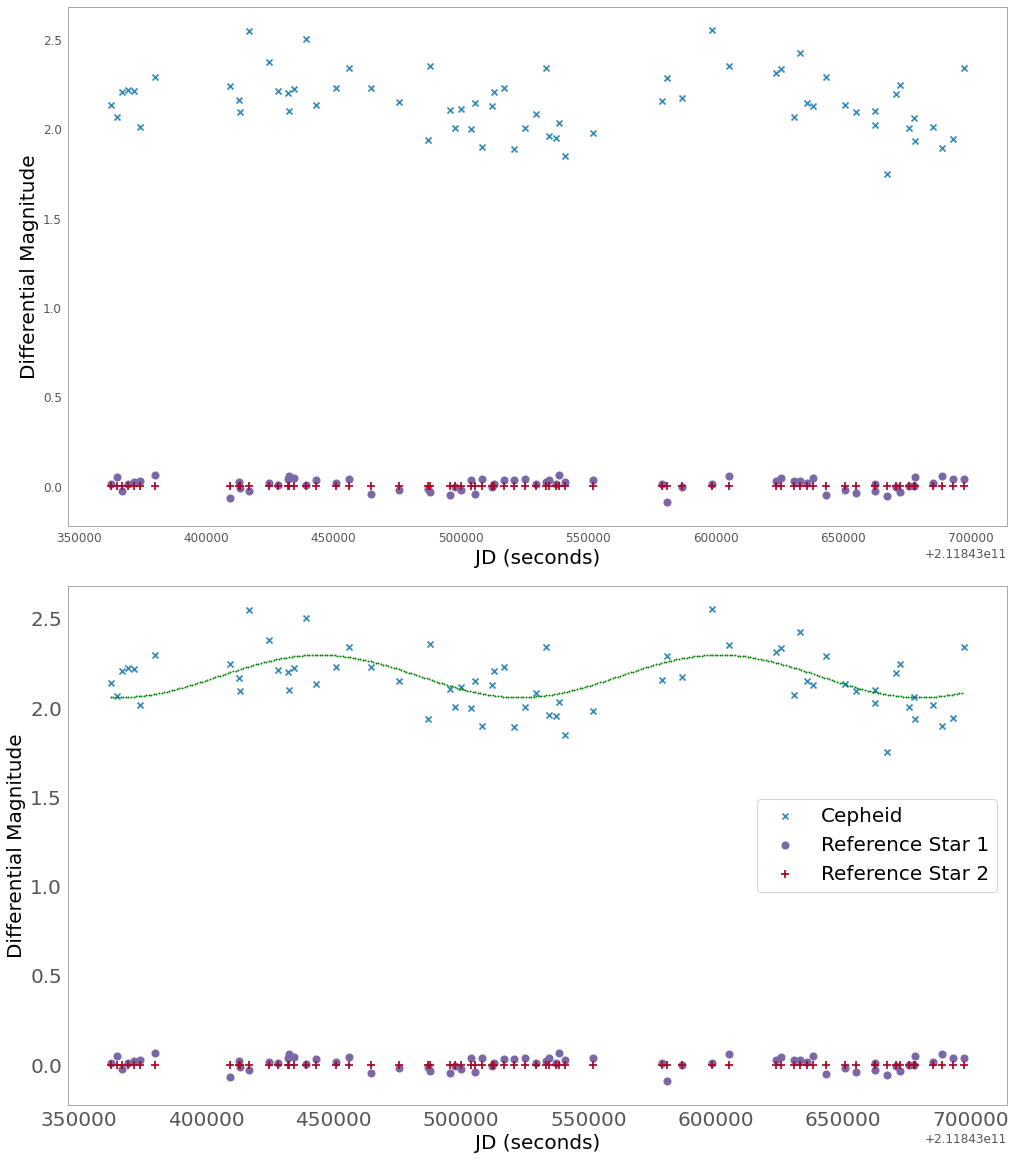

In [279]:

fig, ax = plt.subplots(2,1, figsize=(14,16), constrained_layout=True)

# fig.patch.set_facecolor('lightgrey')
ax[0].grid(False)
ax[1].grid(False)

plt.xticks(fontsize= 20) 
plt.yticks(fontsize= 20) 
ax[0].set_ylabel('Differential Magnitude',fontsize=20)
ax[0].set_xlabel('JD (seconds)', fontsize=20)
ax[1].set_ylabel('Differential Magnitude',fontsize=20)
ax[1].set_xlabel('JD (seconds)', fontsize=20)

ax[0].scatter(df['JD(seconds)'],df['diff_mag_1'],marker='x', label='Cepheid')
ax[0].scatter(df['JD(seconds)'],df['diff_mag_2'],s=50,marker='o', label='Reference Star 1')
ax[0].scatter(df['JD(seconds)'],df['diff_mag_3'],s=50,marker='+', label='Reference Star 2')

ax[1].scatter(df['JD(seconds)'],df['diff_mag_1'],marker='x', label='Cepheid')
ax[1].scatter(df['JD(seconds)'],df['diff_mag_2'],s=50,marker='o', label='Reference Star 1')
ax[1].scatter(df['JD(seconds)'],df['diff_mag_3'],s=50,marker='+', label='Reference Star 2')

plt.legend(prop={'size': 20})

params1, params_covariance1 = optimize.curve_fit(test_func, df['JD(seconds)'], df['diff_mag_1'], p0=[.6, 0.00004, 496.5, 5])
print(params1)

ax[1].scatter(np.arange(df['JD(seconds)'].min(),df['JD(seconds)'].max(), 1000), test_func(np.arange(df['JD(seconds)'].min(),df['JD(seconds)'].max(), 1000), params1[0], params1[1], params1[2], params1[3]),s=1, c='green')
# ax.scatter(np.arange(df['JD(seconds)'].min(),df['JD(seconds)'].max(), 1000), test_func(np.arange(df['JD(seconds)'].min(),df['JD(seconds)'].max(), 1000), .6, 0.00004, 496.5, params1[3]),s=1, c='red')

# plt.savefig('diff-mag.png')

## Lomb-Scargle Method

0.3216957898276346


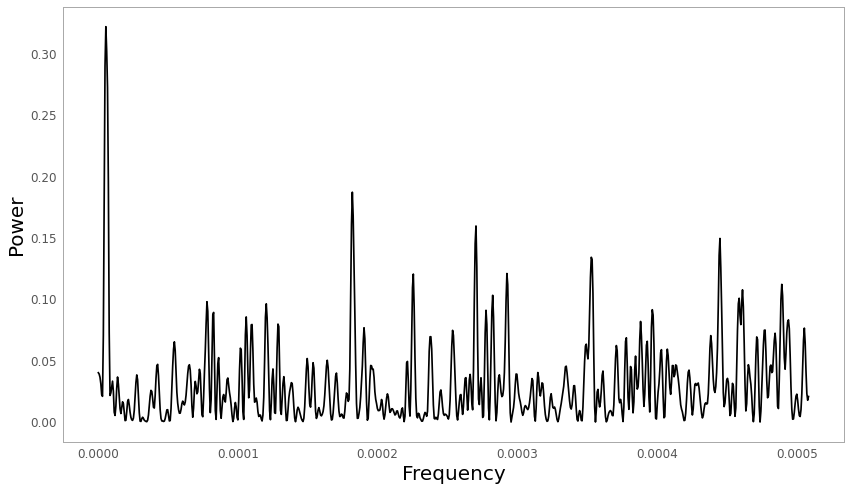

In [280]:
fig, ax = plt.subplots(1,1, figsize=(14,8))
ax.grid(False)
ax.set_ylabel('Power',fontsize=20)
ax.set_xlabel('Frequency', fontsize=20)
frequency, power = LombScargle(df['JD(seconds)'], df['diff_mag_1']).autopower()
plt.plot(frequency, power, color='k' )     
print(power.max())

## Period

In [281]:
result = np.where(power == power.max())
frequency[result]
ls_P = 1/frequency[result] # period from lomb-scargle application
cv_P = 2*np.pi/(params1[1]) # period from curve_fit() 
mf_P = 2*np.pi/(0.00004)  # period from manual fit
# ls_P[0]/86400, cv_P/86400, mf_P/86400
print("From Lomb-Scargle method: ",np.round(ls_P[0]/86400,4),"\nFrom curve fitting: ", np.round(cv_P/86400,4))

From Lomb-Scargle method:  2.0397 
From curve fitting:  1.8181


In [282]:
df['diff_mag_1'].mean(), params1[3]

(2.1478955363055072, 2.177405182478054)

## Absolute Magnitude From P-L Relation

In [319]:
m = -2.9247499463822644 
b = -1.1826619743024827

ls_M_v1 = m*(np.log10(ls_P/86400))+b
cv_M_v1 = m*(np.log10(cv_P/86400))+b

print("From Lomb-Scargle method: ",np.round(ls_M_v1[0],4),"\nFrom curve fitting: ", np.round(cv_M_v1,4))

From Lomb-Scargle method:  -2.0881 
From curve fitting:  -1.9419


## Apparent Magnitude

In [289]:
m_v3 = 14.8
m_v1 = params1[3] + m_v3
m_v1

16.977405182478055

In [290]:
m_v1 - ls_M_v1, m_v1 - cv_M_v1

(array([19.06549411]), 18.919349481143684)

## Distance Modulus

In [291]:
ls_distance = 10**(1+(m_v1 - ls_M_v1[0])/5)
cv_distance = 10**(1+(m_v1 - cv_M_v1)/5)
mf_distance = 10**(1+(m_v1 - mf_M_v1)/5)
print("From Lomb-Scargle method:\n",np.round(ls_distance*3.26/1000000,4),"Mly\n",np.round(ls_distance/1000000,4),"Mpc\nFrom curve fitting:\n", np.round(cv_distance*3.26/1000000,4),"Mly\n",np.round(cv_distance/1000000,4),"Mpc")

From Lomb-Scargle method:
 0.212 Mly
 0.065 Mpc
From curve fitting:
 0.1982 Mly
 0.0608 Mpc


## Comparing Results With Published Data From NED

https://ned.ipac.caltech.edu/byname?objname=smc&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1

In [292]:
ned_dist = pd.read_csv("zid.csv")
(ned_dist)

,(m-M),err(m-M),D(Mpc),Method,Refcode,Notes,SN Name,Redshift,H0,LMCModulus
0,18.07,0.09,0.041,Cepheids,2013A&A...550A..70G,"HV 1345, 1, VK(W), Baade-Wesselink",NaN,NaN,NaN,NaN
1,18.19,0.09,0.043,Cepheids,2013A&A...550A..70G,"HV 1335, 1, VK(W), Baade-Wesselink",NaN,NaN,NaN,NaN
2,18.30,NaN,0.046,Cepheids,2011ApJ...741L..36M,Z,NaN,NaN,NaN,NaN
3,18.70,0.15,0.055,Cepheids,2013A&A...550A..70G,"HV 1328, 1, VK(W), Baade-Wesselink",NaN,NaN,NaN,NaN
4,18.72,NaN,0.056,Cepheids,1994AJ....108..932S,"NGC 0330, 18, VI, overshoot",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
289,18.96,0.02,0.062,Statistical,2015AJ....149..179D,Weighted mean of 304 estimates,NaN,NaN,NaN,NaN
290,18.49,0.80,0.050,Tully est,1988NBGC.C....0000T,B,NaN,NaN,75.0,NaN
291,19.01,0.15,0.063,HII region diameter,1982MNRAS.201..145H,Method 1,NaN,NaN,NaN,NaN
292,19.41,0.13,0.076,HII region diameter,1982MNRAS.201..145H,Method 2,NaN,NaN,NaN,NaN


In [298]:
dist_ceph = ned_dist[ned_dist['Method'] == 'Cepheids']
dist_ceph.describe()

,(m-M),err(m-M),D(Mpc),SN Name,Redshift,H0,LMCModulus
count,118.000000,99.000000,118.000000,0.0,0.0,0.0,25.000000
mean,18.951356,0.067980,0.061839,NaN,NaN,NaN,18.491200
std,0.166266,0.060491,0.004350,NaN,NaN,NaN,0.017156
min,18.070000,0.000000,0.041000,NaN,NaN,NaN,18.450000
25%,18.902500,0.020000,0.060250,NaN,NaN,NaN,18.500000
50%,18.980000,0.050000,0.062000,NaN,NaN,NaN,18.500000
75%,19.010000,0.095000,0.063000,NaN,NaN,NaN,18.500000
max,19.280000,0.280000,0.072000,NaN,NaN,NaN,18.500000


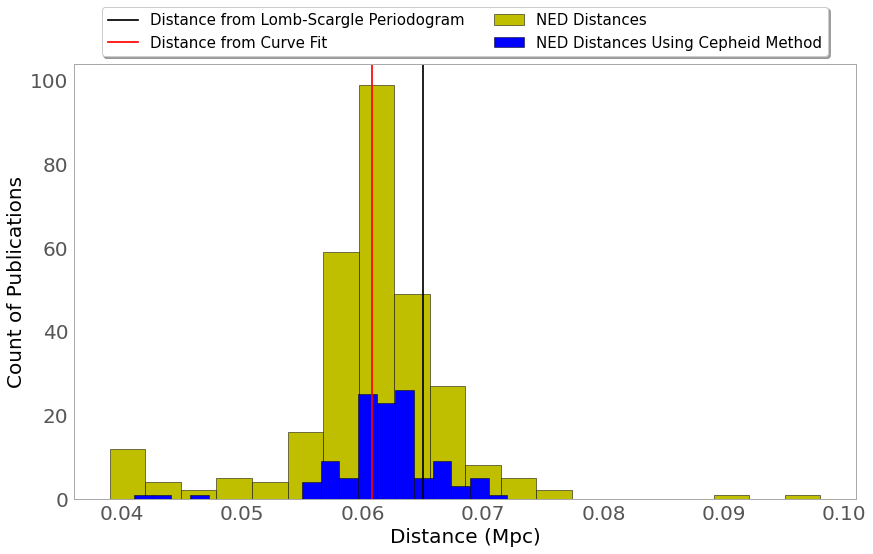

In [309]:
fig, ax = plt.subplots(1,1, figsize=(14,8))
ax.grid(False)
ax.set_ylabel('Count of Publications',fontsize=20)
ax.set_xlabel('Distance (Mpc)', fontsize=20)    
plt.hist(ned_dist['D(Mpc)'], color='y', bins = 20, edgecolor='black', linewidth=.5, label = 'NED Distances')
plt.hist(dist_ceph['D(Mpc)'], color='b', bins = 20, edgecolor='black', linewidth=.5, label = 'NED Distances Using Cepheid Method' )
plt.axvline(x=ls_distance/1000000, color = 'k', label = 'Distance from Lomb-Scargle Periodogram')
plt.axvline(x=cv_distance/1000000, color = 'r', label = 'Distance from Curve Fit')
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

# mu, sigma = scipy.stats.norm.fit(dist_ceph['D(Mpc)'])
# best_fit_line = scipy.stats.norm.pdf(20, mu, sigma)
# # plt.plot(20, best_fit_line)

# plt.legend(prop={'size': 14})
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.),
          fancybox=True, shadow=True, ncol=2, fontsize = 15)